In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os

####################################
############ CONSTANTS #############
####################################
thresh_min      = 20
thresh_max      = 100
s_thresh_min    = 170
s_thresh_max    = 255
ym_per_pix      = 30/720    
xm_per_pix      = 3.7/700   

In [2]:
def image_show(img,text):
    f, ax1 = plt.subplots(1, 1)
    ax1.imshow(img,cmap='gray')
    ax1.set_title(text, fontsize=15)
    plt.show()

def get_binary(img,min,max):
    binary = np.zeros_like(img)
    binary[(img >= min) & (img <= max)] = 1
    return binary

def define_vertices(img,x,y): 
    imshape = img.shape
    xcenter = imshape[1]/2
    return np.float32([(0,imshape[0]),(xcenter-x, y), (xcenter+x,y), (imshape[1],imshape[0])])

## Camera Calibration and Distortion Correction Test  

In [3]:
def undistort(image, mtx, dist):
    image = cv2.undistort(image, mtx, dist, None, mtx)
    return image

In [4]:
def cam_calibration(directory, nx, ny, img_size,save_file = True): 
    images = os.listdir(directory)      
    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

    objpoints = [] 
    imgpoints = []
    
    for img in images:
        gray = cv2.imread(directory+img,cv2.IMREAD_GRAYSCALE)
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            
            if save_file == True:
                print(img)
                cv2.drawChessboardCorners(gray, (nx,ny), corners, ret)
                cv2.imwrite('output_images/calibration/corners_'+ img,gray)
                
            
    if (len(objpoints) == 0 or len(imgpoints) == 0):
        raise Error("Calibration Failed")
            
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    
    if save_file == True:
        for img in images:
             cv2.imwrite('output_images/calibration/undistorted_'+ img, undistort(cv2.imread(directory+img,cv2.IMREAD_GRAYSCALE),mtx,dist))
          
    return mtx, dist

calibration10.jpg
calibration11.jpg
calibration12.jpg
calibration13.jpg
calibration14.jpg
calibration15.jpg
calibration16.jpg
calibration17.jpg
calibration18.jpg
calibration19.jpg
calibration2.jpg
calibration20.jpg
calibration3.jpg
calibration6.jpg
calibration7.jpg
calibration8.jpg
calibration9.jpg


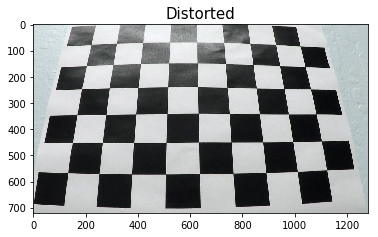

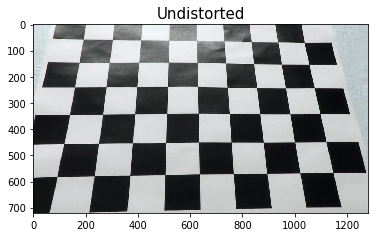

In [5]:
mtx, dist   = cam_calibration('camera_cal/', 9, 6, (720, 1280))
distorted   = cv2.imread("camera_cal/calibration3.jpg")
undistorted = undistort(distorted, mtx, dist)
image_show(distorted,'Distorted')
image_show(undistorted,'Undistorted')

## Color and Gradient Threshold   

In [6]:
def grad_and_color_thresh(img,img_name='',imgshow=True,save_file=False):
    gray            = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    s_channel       = cv2.cvtColor(img,cv2.COLOR_RGB2HLS)[:,:,2]

    abs_sobelx      = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    scaled_sobel    = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    binary_sobel_x  = get_binary(scaled_sobel,thresh_min,thresh_max)
    binary_hls_s    = get_binary(s_channel,s_thresh_min,s_thresh_max)

    combined_binary = np.zeros_like(binary_sobel_x)
    combined_binary[(binary_hls_s == 1) | (binary_sobel_x == 1)] = 1
    if (imgshow==True):
        image_show(s_channel,"S channel")
        image_show(scaled_sobel,"Sobel")
        image_show(binary_sobel_x,"Binary Sobel")
        image_show(binary_hls_s,"Binary S channel")
        image_show(combined_binary,"Combined")
        
    if(save_file==True):
        cv2.imwrite('output_images/extraction/binary_'+img_name, 255*np.dstack((combined_binary,combined_binary,combined_binary)).astype('uint8')  )
   
    return combined_binary

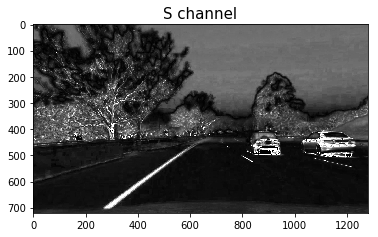

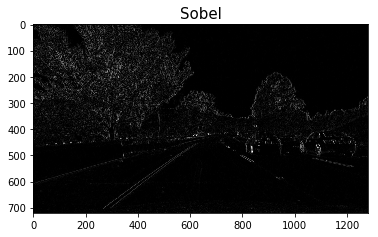

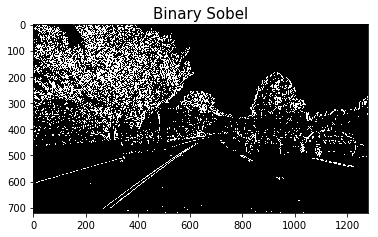

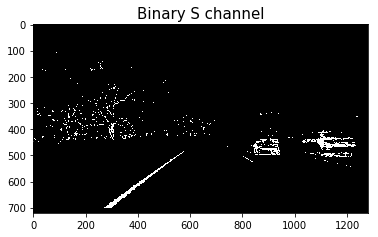

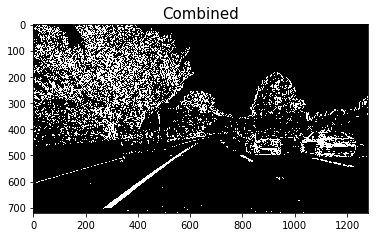

In [7]:
test_image      = cv2.imread('test_images/test6.jpg')
undisorted      = undistort(test_image, mtx, dist)
combined_binary = grad_and_color_thresh(undisorted,'',True,False)

images = os.listdir('test_images/')      
for img in images:
    test_image  = cv2.imread('test_images/'+ img) 
    _           = grad_and_color_thresh(undistort(test_image, mtx, dist),img,False,True)

## Bird's-eye Transform 


In [8]:
def transform(undist,vertices):
    img_size      = (undist.shape[1], undist.shape[0])
    new_top_left  = np.array([vertices[0,0],0])
    new_top_right = np.array([vertices[3,0],0])
    
    offset        = [90,10]
    dst           = np.float32([vertices[0]+offset,new_top_left+offset,new_top_right-offset ,vertices[3]-offset])    
    
    M           = cv2.getPerspectiveTransform(vertices, dst)
    Minv        = cv2.getPerspectiveTransform(dst, vertices) 
    warped      = cv2.warpPerspective(undist, M, img_size, flags=cv2.INTER_LINEAR)
    return warped,Minv

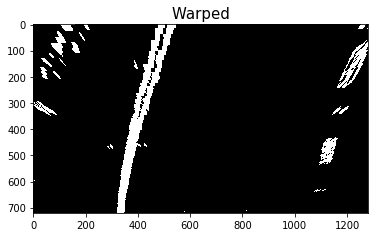

In [9]:
warped,Minv = transform(combined_binary,np.float32([[190,720],[589,457],[698,457],[1145,720]]))
cv2.imwrite('output_images/extraction/warped_test6.jpg',255*np.dstack((warped,warped,warped)).astype('uint8'))
image_show(warped,'Warped')

## Get Lane Lines and Determine Curvature


In [10]:
def get_lines(img,windows_number,im_show = True):
    margin        = 85
    minpix        = 55
      
    l_lane_inds   = []
    r_lane_inds   = []

    out_img       = np.dstack((img, img, img))*255
    ploty         = np.linspace(0, img.shape[0]-1, img.shape[0] )
    nonzero       = img.nonzero()
    nonzeroy      = np.array(nonzero[0])
    nonzerox      = np.array(nonzero[1])
    
    window_height = np.int(img.shape[0]/windows_number)
    
    histogram     = np.sum(img[img.shape[0]//2:,:], axis=0)
    center        = np.int(histogram.shape[0]/2)
    left_line     = np.argmax(histogram[:center])
    right_line    = np.argmax(histogram[center:]) + center
   
    lx_current    = left_line
    rx_current    = right_line
  
    for window in range(windows_number):
        win_y_low       = img.shape[0]   - (window+1)*window_height
        win_y_high      = img.shape[0]   - window*window_height
        win_xleft_low   = lx_current     - margin
        win_xleft_high  = lx_current     + margin
        win_xright_low  = rx_current     - margin
        win_xright_high = rx_current     + margin

        good_left_inds  = ((nonzeroy >= win_y_low)      & 
                           (nonzeroy < win_y_high)      & 
                           (nonzerox >= win_xleft_low)  & 
                           (nonzerox < win_xleft_high)).nonzero()[0]
        
        good_right_inds = ((nonzeroy >= win_y_low)      & 
                           (nonzeroy < win_y_high)      & 
                           (nonzerox >= win_xright_low) &
                           (nonzerox < win_xright_high)).nonzero()[0]
        
        l_lane_inds.append(good_left_inds)
        r_lane_inds.append(good_right_inds)

        if len(good_left_inds) > minpix:
            lx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rx_current = np.int(np.mean(nonzerox[good_right_inds]))
            
    l_lane_inds = np.concatenate(l_lane_inds)
    r_lane_inds = np.concatenate(r_lane_inds)  

    left_fit    = np.polyfit(nonzeroy[l_lane_inds] , nonzerox[l_lane_inds], 2)  
    right_fit   = np.polyfit(nonzeroy[r_lane_inds] , nonzerox[r_lane_inds], 2)
    
    left_fitx   = left_fit [0]*ploty**2 + left_fit [1]*ploty + left_fit[2]
    right_fitx  = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[l_lane_inds], nonzerox[l_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[r_lane_inds], nonzerox[r_lane_inds]] = [0, 0, 255]

    if(im_show==True):
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        plt.show()
    
    return l_lane_inds,r_lane_inds,ploty

In [11]:
def get_x_for_line(line_fit, line_y):
    poly = np.poly1d(line_fit)
    return poly(line_y)

In [12]:
def get_curvature_center(warped,left,right,ploty):
   
    nonzeroy            = np.array(warped[0])
    nonzerox            = np.array(warped[1])
    y_eval              = np.max(ploty)

    left_fit_cr         = np.polyfit(nonzeroy[left]*ym_per_pix, nonzerox[left]*xm_per_pix, 2)
    right_fit_cr        = np.polyfit(nonzeroy[right]*ym_per_pix, nonzerox[right]*xm_per_pix, 2)
    
    left_fitx_bottom_m  = get_x_for_line(left_fit_cr, 720 * ym_per_pix)
    right_fitx_bottom_m = get_x_for_line(right_fit_cr, 720 * ym_per_pix)
    
    left_curvature      = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curvature     = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    center_ideal_m      = 1280 * xm_per_pix / 2

    center_actual_m     = np.mean([left_fitx_bottom_m, right_fitx_bottom_m])
    distance_from_center= abs(center_ideal_m - center_actual_m)
    return left_curvature,right_curvature,distance_from_center

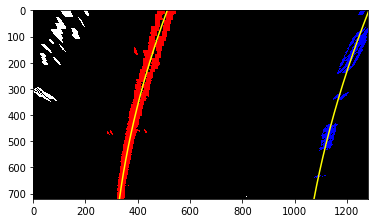

In [13]:
left,right,ploty                 = get_lines(warped,9,True)
left_curvature,right_curvature,_ = get_curvature_center(warped.nonzero(),left,right,ploty)

## Draw region between lane lines


In [14]:
def draw_region(warped,left,right,Minv,undisorted,im_show=True):

    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    nonzero       = warped.nonzero()
    nonzeroy      = np.array(nonzero[0])
    nonzerox      = np.array(nonzero[1])
    
    left_fit    = np.polyfit(nonzeroy[left] , nonzerox[left], 2)  
    right_fit   = np.polyfit(nonzeroy[right] , nonzerox[right], 2)
    
    left_fitx   = left_fit [0]*ploty**2 + left_fit [1]*ploty + left_fit[2]
    right_fitx  = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    pts_left    = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right   = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts         = np.hstack((pts_left, pts_right))

    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    newwarp     = cv2.warpPerspective(color_warp, Minv, (undisorted.shape[1], undisorted.shape[0])) 
    result      = cv2.addWeighted(undisorted, 1, newwarp, 0.3, 0)
    if(im_show==True):
        plt.imshow(result)
        plt.show()
    return result

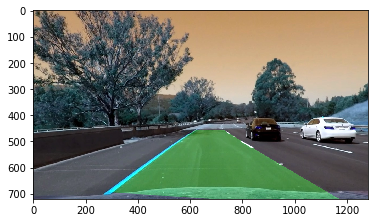

True

In [15]:
result = draw_region(warped,left,right,Minv,undisorted,True)
cv2.imwrite('output_images/extraction/project_test6.jpg',result)

In [16]:
def process_frame(img):
    undisorted                     = undistort(img, mtx, dist)
    combined_binary                = grad_and_color_thresh(undisorted,False,False)
    warped,Minv                    = transform(combined_binary,np.float32([[190,720],[589,457],[698,457],[1145,720]]))
    left,right,ploty               = get_lines(warped,9,False)
    l_curv,r_curv,d_center         = get_curvature_center(warped.nonzero(),left,right,ploty)
    result                         = draw_region(warped,left,right,Minv,undisorted,False)
     
    cv2.putText(result,'Radius of Left Curvature:  %.2fm' % l_curv,(20,40), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2)
    cv2.putText(result,'Radius of Right Curvature: %.2fm' % r_curv,(20,80), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2)
    cv2.putText(result,'Distance from Center:      %.2fm' % d_center,(20,120), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2)
    return result
    

In [17]:
from moviepy.editor import VideoFileClip

white_output = 'out12.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_frame) 

%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video out12.mp4
[MoviePy] Writing video out12.mp4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [03:01<00:00,  6.83it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: out12.mp4 

Wall time: 3min 2s
